### Prectical implementation on GAN

In [1]:
# !cat /proc/cpuinfo
!nvidia-smi


Wed Apr 10 10:43:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# !pip install tensorflow keras
# !pip install --upgrade keras
# !pip install keras-vis


In [ ]:
#Importing all the necessary libraries
from tensorflow import keras
from tensorflow.keras.datasets.cifar10 import load_data
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from tensorflow.keras.utils import plot_model
import numpy as np

### Plotting the images, just for testing

170498071/170498071 [==============================] - 13s 0us/step


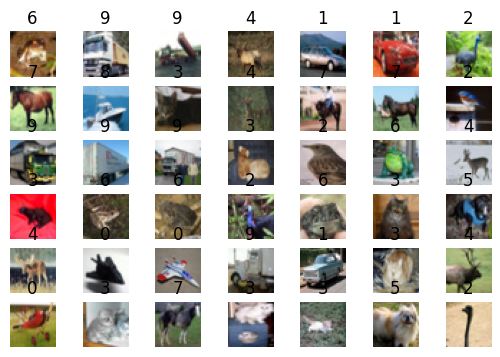

In [ ]:
#Example of loading and plotting the cifar10 dataset
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot
#load the images into memory
(trainX, trainY), (testX, testY) = load_data()
#plot image from the training dataset
for i in range(42):
  #define subplots
  pyplot.subplot(7,7,1+i)
  #trun of axis
  pyplot.axis('off')
  #plot raw pixel data
  pyplot.imshow(trainX[i])
  pyplot.title(trainY[i][0])
pyplot.show()

### Defining Descriminator CNN Architecture, to classify  fake or real images.

In [ ]:
#define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  #normal
  ## using leakyRelu, b
  model.add(Conv2D(64, kernel_size=(3,3), padding='same', input_shape = in_shape))   # same means pass image with padding
  model.add(LeakyReLU(alpha= 0.2))
  #downsample
  model.add(Conv2D(128, kernel_size=(3,3), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #downsample
  model.add(Conv2D(128, kernel_size=(3,3), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #downsample
  model.add(Conv2D(256, kernel_size=(3,3), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #classifier
  model.add(Flatten())
  model.add(Dropout(0.4))       # set dropout ratio on flatten input
  model.add(Dense(1,activation='sigmoid'))

  #compile model
  adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)     # adam optimizer with specific parameters
  model.compile(loss='binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

  return model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

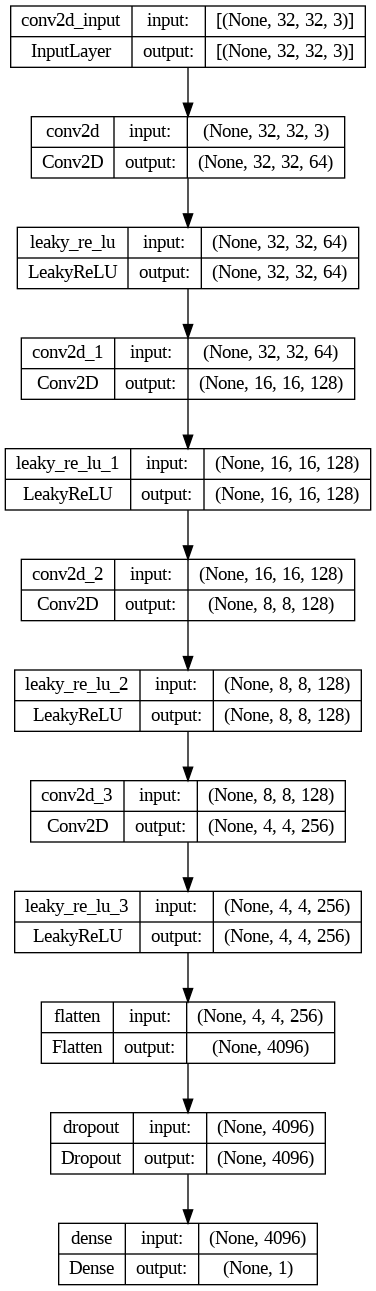

In [ ]:
#define model
model = define_discriminator()
#summarize the model
model.summary()
#plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

### function to laoding cifar10 dataset from tensorflo

In [ ]:
def load_real_samples():
  #load cifar10 dataset
  (trainX,_), (_,_) = load_data()
  #convert from unsigned int to float
  X = trainX.astype('float32')
  #scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X

#test
x = load_real_samples()
x.shape     , trainY.shape

((50000, 32, 32, 3), (50000, 1))

In [ ]:
# randint prectise to understand
np.random.randint(10)   # in between 0 -  10 generate one int number
np.random.randint(2,5)  # in between  0 -  5 generate one int number
np.random.randint(1,5,5)  # in between 1 - 5 generate 5 element

array([3, 2, 3, 3, 4])

In [ ]:
# Generating random 64 indexes in between 0  - 50000
indexes = np.random.randint(0,50000,64)
indexes

array([10189, 14388,  3831, 35765, 14494, 41250, 39135, 36183, 39579,
        4569, 33642, 49141, 44300,  8975, 43231,  9072, 20291, 29663,
       12088,   263, 16863, 46058,  8527, 42136, 34049, 43520, 36007,
        3583, 46001, 20541,  6159, 13931, 20878, 15871, 39028,  5808,
       14016,  5909, 47280, 38077,  7000,  7319, 18778, 41379, 29880,
       45684, 38255,  6572, 12596,  5973, 19243, 15288,  5450, 16628,
       32052, 11316, 40059, 34354, 47111, 41781,  7693,  3639,  8173,
       27254])

### Real 64 images fetch from dataset, and assign label = 1

In [ ]:
# Select real samples images and assign label = 1 , batch_size = 64
def generate_real_samples(dataset,n_samples):
  #choose random instances
  index = np.random.randint(0, dataset.shape[0], n_samples)   # choose 64 elements in between 0 - 50000
  #retrive selected images
  X = dataset[index]   # randomly choosing 64 elements from the X
  #generate real class labels: (1)
  y = np.ones((n_samples,1))

  return X,y



x,y = generate_real_samples(x,64)
print(x.shape)
print(y.shape)

(64, 32, 32, 3)
(64, 1)


In [ ]:
# random function
np.random.rand(3) # generate 3 elements in a 1D array range of element 0 - 1.
np.random.rand(3,2)  #generate 2D array (3,2) with filling in range 0 - 1.
np.random.rand(3,3,2)  #generate 3D array (3,3,2) with filling in range 0 - 1.

array([[[0.09562533, 0.70075313],
        [0.6976458 , 0.89706764],
        [0.01319289, 0.43917335]],

       [[0.92987452, 0.21787632],
        [0.98674515, 0.67900842],
        [0.96890887, 0.74315348]],

       [[0.33567779, 0.20699618],
        [0.73203342, 0.45921252],
        [0.57648984, 0.28492196]]])

### Generate 64 fake image of noise to train Desciminator, using numpy array and assign labell to all as label= 0<br>
### and also we have normalize our wieghts in between -1   to 1.<br>
### because we have already normalize our real images.

In [ ]:
#generate n fake samples with class labels
def generate_fake_samples(n_samples):
  #generate uniform random numbers in [0,1]
  X = np.random.rand(32 * 32 *3 * n_samples)
  #update to have the range [-1,1]
  X = -1 + X * 2
  # reshape into a batch of color images
  X = X.reshape((n_samples, 32,32,3))

  #generate fake class labels: (0)
  y = np.zeros((n_samples, 1))

  return X, y


x,y = generate_fake_samples(64)
print(x.shape)
print(y.shape)


## Now we have 64 real images with labels = 1   and
            #  64 fake images with labels = 0

(64, 32, 32, 3)
(64, 1)


### # lets see our noise images how they look like

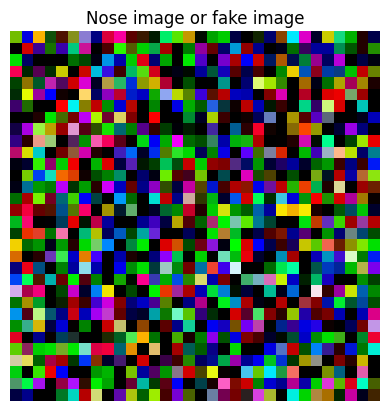

In [ ]:
 import matplotlib.pyplot as plt
 import warnings
 warnings.filterwarnings('ignore')

 plt.imshow(x[0])
 plt.title("Nose image or fake image")
 plt.axis("off")
 plt.show()


### Descriminator training on real and fake images,

In [ ]:
#Train the discriminator model temporarily
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
  half_batch = int(n_batch / 2)
  #manually enumerate epochs
  for i in range(n_iter):
    #get randomly selected real samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    #update discriminator on real samples
    _,real_acc = model.train_on_batch(X_real, y_real)
    #generates fake examples
    X_fake, y_fake = generate_fake_samples(half_batch)
    #update discriminator on fake samples
    _,fake_acc = model.train_on_batch(X_fake, y_fake)
    #summarize performance
    print('>%d real = %.0f%% fake= %.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:
# Example of training

#define the discriminator model
model = define_discriminator()
#load image data
dataset = load_real_samples()
#fit the model
train_discriminator(model, dataset)

>1 real = 50% fake= 0%
>2 real = 97% fake= 0%
>3 real = 97% fake= 8%
>4 real = 97% fake= 17%
>5 real = 97% fake= 50%
>6 real = 100% fake= 88%
>7 real = 98% fake= 100%
>8 real = 95% fake= 100%
>9 real = 89% fake= 100%
>10 real = 89% fake= 100%
>11 real = 92% fake= 100%
>12 real = 98% fake= 100%
>13 real = 95% fake= 100%
>14 real = 100% fake= 100%
>15 real = 100% fake= 100%
>16 real = 100% fake= 100%
>17 real = 100% fake= 100%
>18 real = 98% fake= 100%
>19 real = 100% fake= 100%
>20 real = 100% fake= 100%


### Test Descriminator by getting prediction on unseen data point,

In [ ]:
# new fake image generating
fake_data_point = np.random.rand(32*32*3*1)    # generates in between range 0  to 1.
fake_point = -1 + fake_data_point *2
fake_point = fake_point.reshape((32,32,3))
fake_point.shape  , dataset[0].shape


((32, 32, 3), (32, 32, 3))

In [ ]:
# Getting prediction on both data point
prediction_on_single_point = model.predict(np.expand_dims(dataset[0],axis=0))>0.5
print("Prediction on real image : ",(prediction_on_single_point>0.5).astype(int)[0][0])
print()
prediction_on_single_point = model.predict(np.expand_dims(fake_point,axis=0))>0.5
print("Prediction on fake image : ",(prediction_on_single_point>0.5).astype(int)[0][0])

1/1 [==============================] - 0s 19ms/step
Prediction on real image :  1

1/1 [==============================] - 0s 17ms/step
Prediction on fake image :  0


### Work on Generator part, generator responsible to generate new data

In [ ]:
# now work on Generator
from keras.layers import Reshape  # to reshape the ANN flat layer
from keras.layers import Conv2DTranspose

In [ ]:
#define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  #foundation for 4x4 image   ( FFN NETWORK )
  n_nodes = 256 * 4* 4         # 4096 shape is output of last hidden layer of descriminator
  model.add(Dense(n_nodes, input_dim = latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))  # to reshape flat output of dense layer into an image form

  #upsample to 8x8 # it will multiply by 2 in height , width of the input image
  model.add(Conv2DTranspose(128, kernel_size=(4,4), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #upsample to 16x16
  model.add(Conv2DTranspose(128, kernel_size=(4,4), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #upsample to 32x32
  model.add(Conv2DTranspose(128, kernel_size=(4,4), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #output layer
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

  return model

# Conv2DTranspose layer is used for upsampling and creating higher-resolution feature maps.upsampling by a factor of 2 in both dimensions
# activation tanh because we have pass image in -1 to 1 range in
# descrimanator
# so finally we will get output layer by the output layer of Generator with in this shape --> (32*32*3)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         524416    
 anspose)                                                        
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                           

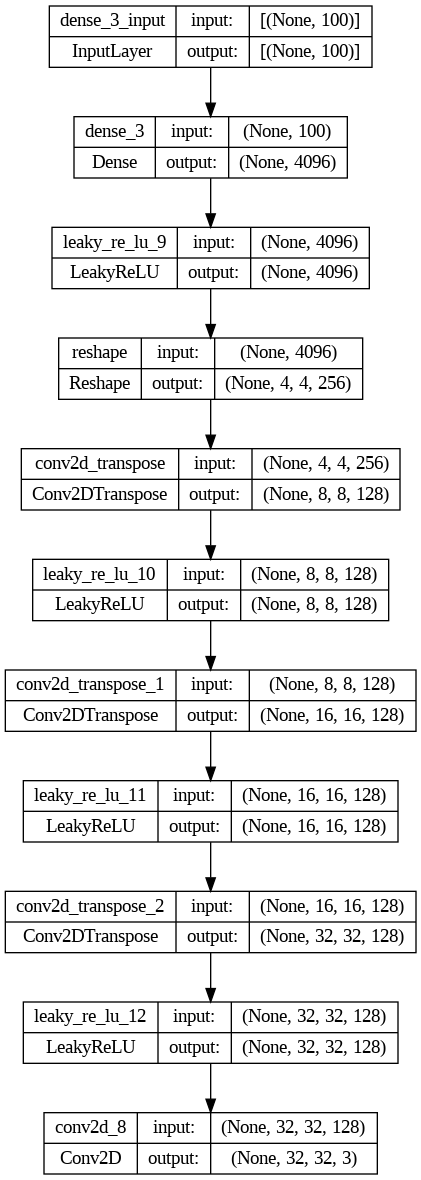

In [ ]:
#define the size of the latent space
latent_dim = 100
#define the generator model
model = define_generator(latent_dim)
#summarize the model
model.summary()
#plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
np.random.randn(100*64)

### Generate latent point inputs for Generator

In [ ]:
#generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  #generate point in the latent space
  x_input = np.random.randn(latent_dim * n_samples)  # 1D -->  6400  =  100 * 64
  #reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)

  return x_input

data = generate_latent_points(100,64)
print(data.shape)

(64, 100)


### it wil generate 40 sample clean images, by the generator

In [ ]:
#use the generator to generate n fake examples with class labels
def generate_fake_images(g_model, latent_dim, n_sample):
  #generate point in the latent space
  x_input = generate_latent_points(latent_dim, n_sample)
  #predict output from generator
  X = g_model.predict(x_input)
  #create a fake class label: (0)
  y = np.zeros((n_sample,1))

  return X,y


2/2 [==============================] - 1s 206ms/step


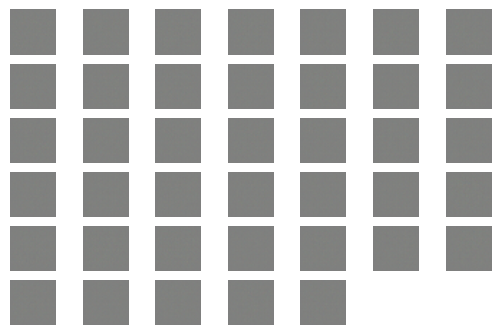

In [ ]:
#size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
#generate samples
n_sample = 40
X,_ = generate_fake_images(model, latent_dim, n_sample)
#scale the pixel value from [-1,1] to [0,1]
X = (X + 1) / 2.0
#plot the generated samples
for i in range(n_sample):
  #define subplots
  pyplot.subplot(7,7,1+i)
  #turn of axis
  pyplot.axis('off')
  #plot raw pixel data
  pyplot.imshow(X[i])
pyplot.show()


In [ ]:
#defining the combined generator and discriminator model, for updating the generator
def define_gan(g_model,d_model):
  #make weights in the discriminator not trainable
  d_model.trainable = False
  #connect them
  model = Sequential()
  #add generator
  model.add(g_model)
  #add discriminator
  model.add(d_model)
  #compile model
  adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer = adam)

  return model


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_5 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1988612 (7.59 MB)
Trainable params: 1466115 (5.59 MB)
Non-trainable params: 522497 (1.99 MB)
_________________________________________________________________


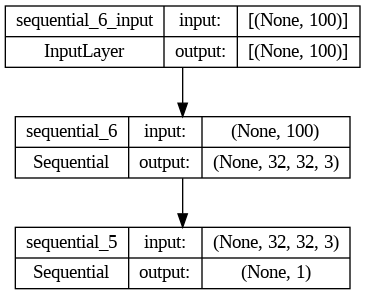

In [ ]:
# size of the latent space
latent_dim = 100
#create discriminator
d_model = define_discriminator()
#create generator
g_model = define_generator(latent_dim)
#create the GAN
gan_model = define_gan(g_model, d_model)
#summarize the gan
gan_model.summary()
#plot the gan model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#train the generator & dicriminator
def train(g_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  bat_per_epo = int(dataset.shape[0]/n_batch)
  half_batch = int(n_batch/2)
  #manually enumerate epochs
  for i in range(n_epochs):
    #enumerate batches over the training set
    for j in range(bat_per_epo):
      #get randomly selected real samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      #update discriminator model weights
      d_loss1,_ = d_model.train_on_batch(X_real, y_real)
      #generate fake examples
      X_fake, y_fake = generate_fake_images(g_model,latent_dim, half_batch)
      #update discriminator model weights
      d_loss2,_ = d_model.train_on_batch(X_fake, y_fake)
      #prepare points in the latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for fake samples
      y_gan = np.ones((n_batch,1))
      #update the generator via the discriminator'r error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      #summarize loss on this batches
      print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' %
            (i+i, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

    #evaluate the model performance sometimes
    if (i+1) % 10 ==0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)




In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epochs, g_model, d_model, dataset, latent_dim, n_sample=150):
  #prepare real sample
  X_real, y_real = generate_real_samples(dataset, n_sample)
  #evaluate dicriminator on real examples
  _,acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  #prepare fake examples
  X_fake, y_fake = generate_fake_images(g_model,latent_dim, n_sample)
  #evaluate dicriminator on fake examples
  _,acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(">Accuracy real: %.0f%%, fake: %.0f%%" % (acc_real*100, acc_fake*100))
  #save plot
  save_plot(X_fake, epochs)
  # save the generator model title file
  filename = 'generator_model_%03d.h5' % (epochs+1)
  g_model.save(filename)



In [ ]:
# create and save a plot of generated images
def save_plot(examples, epochs,n=7):
  #scale the pixel value from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
  #plot the generated samples
  for i in range(n*n):
    #define subplots
    pyplot.subplot(n,n,1+i)
    #turn of axis
    pyplot.axis('off')
    #plot raw pixel data
    pyplot.imshow(examples[i])
  #save plot as file
  filename = 'generated_plot_%03d.png' % (epochs+1)
  pyplot.savefig(filename)
  pyplot.close()




In [ ]:
train(g_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
>6, 232/390, d1=0.551, d2=0.525, g=1.291
2/2 [==============================] - 0s 6ms/step
>6, 233/390, d1=0.580, d2=0.564, g=1.354
2/2 [==============================] - 0s 5ms/step
>6, 234/390, d1=0.583, d2=0.471, g=1.267
2/2 [==============================] - 0s 5ms/step
>6, 235/390, d1=0.504, d2=0.542, g=1.231
2/2 [==============================] - 0s 5ms/step
>6, 236/390, d1=0.640, d2=0.541, g=1.302
2/2 [==============================] - 0s 5ms/step
>6, 237/390, d1=0.551, d2=0.593, g=1.294
2/2 [==============================] - 0s 13ms/step
>6, 238/390, d1=0.617, d2=0.563, g=1.109
2/2 [==============================] - 0s 7ms/step
>6, 239/390, d1=0.586, d2=0.575, g=1.167
2/2 [==============================] - 0s 5ms/step
>6, 240/390, d1=0.538, d2=0.522, g=1.238
2/2 [==============================] - 0s 6ms/step
>6, 241/390, d1=0.633, d2=0.482, g=1.269
2/2 [=======================

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
>26, 232/390, d1=0.675, d2=0.646, g=0.899
2/2 [==============================] - 0s 5ms/step
>26, 233/390, d1=0.637, d2=0.651, g=1.077
2/2 [==============================] - 0s 5ms/step
>26, 234/390, d1=0.692, d2=0.610, g=0.951
2/2 [==============================] - 0s 6ms/step
>26, 235/390, d1=0.656, d2=0.605, g=0.880
2/2 [==============================] - 0s 7ms/step
>26, 236/390, d1=0.674, d2=0.610, g=0.874
2/2 [==============================] - 0s 4ms/step
>26, 237/390, d1=0.680, d2=0.714, g=0.785
2/2 [==============================] - 0s 4ms/step
>26, 238/390, d1=0.658, d2=0.750, g=0.863
2/2 [==============================] - 0s 5ms/step
>26, 239/390, d1=0.730, d2=0.647, g=0.903
2/2 [==============================] - 0s 4ms/step
>26, 240/390, d1=0.677, d2=0.623, g=0.986
2/2 [==============================] - 0s 5ms/step
>26, 241/390, d1=0.660, d2=0.664, g=0.925
2/2 [==============

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
>46, 232/390, d1=0.608, d2=0.653, g=0.866
2/2 [==============================] - 0s 6ms/step
>46, 233/390, d1=0.672, d2=0.630, g=0.885
2/2 [==============================] - 0s 5ms/step
>46, 234/390, d1=0.690, d2=0.630, g=0.868
2/2 [==============================] - 0s 5ms/step
>46, 235/390, d1=0.618, d2=0.610, g=0.916
2/2 [==============================] - 0s 5ms/step
>46, 236/390, d1=0.681, d2=0.627, g=0.881
2/2 [==============================] - 0s 4ms/step
>46, 237/390, d1=0.656, d2=0.625, g=0.862
2/2 [==============================] - 0s 4ms/step
>46, 238/390, d1=0.652, d2=0.635, g=0.863
2/2 [==============================] - 0s 4ms/step
>46, 239/390, d1=0.688, d2=0.648, g=0.841
2/2 [==============================] - 0s 5ms/step
>46, 240/390, d1=0.669, d2=0.633, g=0.831
2/2 [==============================] - 0s 5ms/step
>46, 241/390, d1=0.672, d2=0.618, g=0.823
2/2 [==============

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 6ms/step
>66, 232/390, d1=0.642, d2=0.624, g=0.836
2/2 [==============================] - 0s 6ms/step
>66, 233/390, d1=0.647, d2=0.658, g=0.849
2/2 [==============================] - 0s 4ms/step
>66, 234/390, d1=0.604, d2=0.655, g=0.835
2/2 [==============================] - 0s 6ms/step
>66, 235/390, d1=0.683, d2=0.636, g=0.840
2/2 [==============================] - 0s 5ms/step
>66, 236/390, d1=0.668, d2=0.654, g=0.836
2/2 [==============================] - 0s 5ms/step
>66, 237/390, d1=0.671, d2=0.678, g=0.869
2/2 [==============================] - 0s 5ms/step
>66, 238/390, d1=0.685, d2=0.622, g=0.853
2/2 [==============================] - 0s 5ms/step
>66, 239/390, d1=0.664, d2=0.641, g=0.838
2/2 [==============================] - 0s 5ms/step
>66, 240/390, d1=0.682, d2=0.673, g=0.821
2/2 [==============================] - 0s 4ms/step
>66, 241/390, d1=0.656, d2=0.706, g=0.846
2/2 [==============

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 9ms/step
>86, 232/390, d1=0.612, d2=0.678, g=0.747
2/2 [==============================] - 0s 5ms/step
>86, 233/390, d1=0.642, d2=0.762, g=0.802
2/2 [==============================] - 0s 9ms/step
>86, 234/390, d1=0.619, d2=0.690, g=0.854
2/2 [==============================] - 0s 5ms/step
>86, 235/390, d1=0.608, d2=0.619, g=0.823
2/2 [==============================] - 0s 5ms/step
>86, 236/390, d1=0.644, d2=0.675, g=0.839
2/2 [==============================] - 0s 5ms/step
>86, 237/390, d1=0.598, d2=0.633, g=0.862
2/2 [==============================] - 0s 5ms/step
>86, 238/390, d1=0.655, d2=0.639, g=0.832
2/2 [==============================] - 0s 5ms/step
>86, 239/390, d1=0.698, d2=0.701, g=0.890
2/2 [==============================] - 0s 5ms/step
>86, 240/390, d1=0.689, d2=0.638, g=0.892
2/2 [==============================] - 0s 5ms/step
>86, 241/390, d1=0.678, d2=0.592, g=0.886
2/2 [==============

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
>106, 232/390, d1=0.690, d2=0.657, g=0.834
2/2 [==============================] - 0s 6ms/step
>106, 233/390, d1=0.618, d2=0.629, g=0.838
2/2 [==============================] - 0s 4ms/step
>106, 234/390, d1=0.612, d2=0.645, g=0.821
2/2 [==============================] - 0s 6ms/step
>106, 235/390, d1=0.648, d2=0.662, g=0.888
2/2 [==============================] - 0s 4ms/step
>106, 236/390, d1=0.596, d2=0.623, g=0.904
2/2 [==============================] - 0s 5ms/step
>106, 237/390, d1=0.679, d2=0.602, g=0.848
2/2 [==============================] - 0s 5ms/step
>106, 238/390, d1=0.691, d2=0.681, g=0.881
2/2 [==============================] - 0s 5ms/step
>106, 239/390, d1=0.611, d2=0.663, g=0.863
2/2 [==============================] - 0s 4ms/step
>106, 240/390, d1=0.664, d2=0.567, g=0.862
2/2 [==============================] - 0s 4ms/step
>106, 241/390, d1=0.637, d2=0.605, g=0.864
2/2 [====

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
>126, 232/390, d1=0.664, d2=0.572, g=0.887
2/2 [==============================] - 0s 5ms/step
>126, 233/390, d1=0.654, d2=0.631, g=0.848
2/2 [==============================] - 0s 3ms/step
>126, 234/390, d1=0.627, d2=0.635, g=0.902
2/2 [==============================] - 0s 4ms/step
>126, 235/390, d1=0.600, d2=0.620, g=0.944
2/2 [==============================] - 0s 6ms/step
>126, 236/390, d1=0.574, d2=0.566, g=0.866
2/2 [==============================] - 0s 5ms/step
>126, 237/390, d1=0.678, d2=0.582, g=0.894
2/2 [==============================] - 0s 7ms/step
>126, 238/390, d1=0.613, d2=0.635, g=0.889
2/2 [==============================] - 0s 6ms/step
>126, 239/390, d1=0.541, d2=0.704, g=0.915
2/2 [==============================] - 0s 6ms/step
>126, 240/390, d1=0.609, d2=0.632, g=0.956
2/2 [==============================] - 0s 4ms/step
>126, 241/390, d1=0.651, d2=0.651, g=0.933
2/2 [====

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
>146, 232/390, d1=0.666, d2=0.605, g=0.959
2/2 [==============================] - 0s 5ms/step
>146, 233/390, d1=0.627, d2=0.569, g=0.997
2/2 [==============================] - 0s 4ms/step
>146, 234/390, d1=0.743, d2=0.610, g=0.930
2/2 [==============================] - 0s 5ms/step
>146, 235/390, d1=0.676, d2=0.608, g=0.904
2/2 [==============================] - 0s 5ms/step
>146, 236/390, d1=0.626, d2=0.686, g=0.914
2/2 [==============================] - 0s 5ms/step
>146, 237/390, d1=0.597, d2=0.562, g=0.960
2/2 [==============================] - 0s 4ms/step
>146, 238/390, d1=0.627, d2=0.604, g=0.916
2/2 [==============================] - 0s 4ms/step
>146, 239/390, d1=0.605, d2=0.591, g=0.946
2/2 [==============================] - 0s 5ms/step
>146, 240/390, d1=0.616, d2=0.603, g=0.920
2/2 [==============================] - 0s 5ms/step
>146, 241/390, d1=0.562, d2=0.621, g=0.973
2/2 [====

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
>160, 325/390, d1=0.653, d2=0.568, g=1.010
2/2 [==============================] - 0s 5ms/step
>160, 326/390, d1=0.705, d2=0.663, g=0.996
2/2 [==============================] - 0s 5ms/step
>160, 327/390, d1=0.649, d2=0.593, g=0.924
2/2 [==============================] - 0s 5ms/step
>160, 328/390, d1=0.592, d2=0.664, g=0.931
2/2 [==============================] - 0s 5ms/step
>160, 329/390, d1=0.637, d2=0.635, g=0.986
2/2 [==============================] - 0s 4ms/step
>160, 330/390, d1=0.693, d2=0.553, g=0.954
2/2 [==============================] - 0s 6ms/step
>160, 331/390, d1=0.623, d2=0.680, g=0.968
2/2 [==============================] - 0s 6ms/step
>160, 332/390, d1=0.629, d2=0.652, g=1.019
2/2 [==============================] - 0s 6ms/step
>160, 333/390, d1=0.653, d2=0.563, g=1.041
2/2 [==============================] - 0s 5ms/step
>160, 334/390, d1=0.563, d2=0.526, g=0.983
2/2 [====

# Generation after training

4/4 [==============================] - 0s 7ms/step


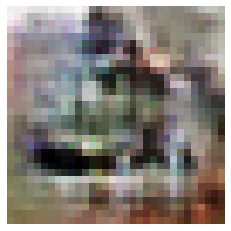

100

In [ ]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot


def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input


def create_plot(examples, n):
  for i in range(n * n):
    pyplot.subplot(n,n,1+i)
    pyplot.axis("off")
    pyplot.imshow(examples[i, :, :])
  pyplot.show()


#load model
model = load_model("/content/generator_model_010.h5")
latent_point = generate_latent_points(100,100)
X = model.predict(latent_point)

X = (X+1)/2.0
create_plot(X,1)

X.shape[0]